## Collecting images from the AIC

The AIC has an extensive API (https://api.artic.edu/docs/) that allows for collection of images. The preferred way is to download a large set of metadata, preselect on the basis of this metadata, and then download the image set.

Full metadata can be downloaded under the following link:
https://artic-api-data.s3.amazonaws.com/artic-api-data.tar.bz2

Honestly, I never really worked with querying large datasets, and this one in particular seems to be very weirdly organised. I will skip the manual download here and instead go with the master_list, which offers a pre-selection of images, and was used in a previous study on artwork memorability (https://www.pnas.org/doi/10.1073/pnas.2302389120).

In [1]:
import pandas as pd

master_df = pd.read_csv('master_list.csv')
master_df.head()

image_id  artwork_id           artist  width  \
0  583b892c-d2d9-ea0c-1cfb-719ee1207189     90335.0  Francis Picabia   3447   
1  33b96726-572b-fdba-2020-078bf1a9efd4     73340.0   Marianne Boers   3000   
2  28f20fcd-a5b3-04b3-2dc9-4c5c79ff7b6b     71978.0     Max Beckmann   3000   
3  711f05a5-3186-6cc8-07ac-50896f804e86         NaN     Paul Cezanne   4019   
4  099a5420-58c0-f29c-baaa-79019aadb48e    228850.0   Raimer Jochims   4666   

   height  aspect_ratio  colorfulness     HR    FAR     CR    RESMEM  
0    4023      0.856823       54.8520  0.976  0.024  0.952  0.836786  
1    2730      1.098901       77.0544  0.950  0.000  0.950  0.906281  
2    2100      1.428571       24.7851  0.927  0.000  0.927  0.934639  
3    5826      0.689839       19.3934  0.951  0.024  0.927  0.852770  
4    3111      1.499839       52.0929  0.950  0.024  0.926  0.892886

We can for example plot the distribution of aspect ratios. 

<Axes: xlabel='aspect_ratio', ylabel='Count'>

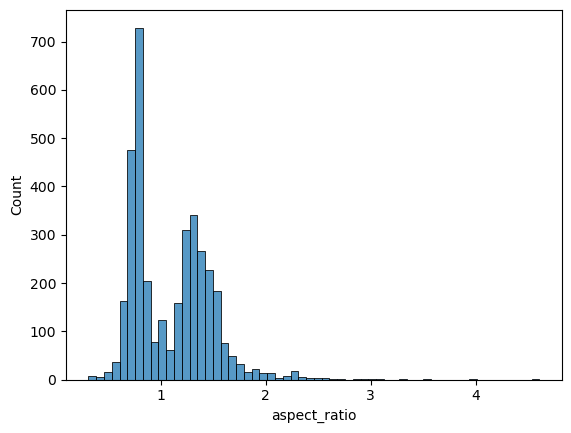

In [2]:
import seaborn as sns

sns.histplot(master_df['aspect_ratio'])

This shows us that most aspect ratios are below 1, with many also being under 2. We can now select for a small subset of these

In [11]:
#filter aspect rations equal to 1.5
print(f"shape of master_df: {master_df.shape}")
filtered_df = master_df[(master_df['aspect_ratio'] < 1.51) & (master_df['aspect_ratio'] > 1.49)]
print(f"shape of filtered_df: {filtered_df.shape}")

shape of master_df: (3659, 11)
shape of filtered_df: (85, 11)


We can now download these images by calling from AIC

In [4]:
import requests
import os

#clear directory
if not os.path.exists('image_collection'):
    os.makedirs('image_collection')
else:
    for f in os.listdir('image_collection'):
        os.remove(os.path.join('image_collection', f))


for image_id in filtered_df['image_id']:
    print(f"Downloading {image_id}")
    url = f"https://www.artic.edu/iiif/2/{image_id}/full/843,/0/default.jpg" # note the 843 pixel width, which is the standard for the AIC, however larger widths are possible for most images
    download_path = f"image_collection/{image_id}.jpg"
    response = requests.get(url)
    if response.status_code == 200:
            with open(download_path, "wb") as f:
                for chunk in response.iter_content(1024):
                    f.write(chunk)
    else:
        #remove from dataframe
        filtered_df = filtered_df[filtered_df['image_id'] != image_id]
        print(f"Failed to download {download_path}")

print("Done")

Failed to download image_collection/cb097c1a-2695-d1b0-0f9b-e5796c7a43c8.jpg
Failed to download image_collection/d0708a7d-6b18-3ce7-6a28-070ef9a1b00f.jpg
Done


Next, we will showcase some basics of the similarity estimation between different images. For this, we will run a small visual CNN, and extract activations from a latent layer, which are assumed to represent semantic features. Calculating the pairwise cosine similarities between these activations allows us to estimate images' similarities.

First, let us load and run a small CNN.

In [5]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# Load pretrained MobileNetV2
model = models.mobilenet_v2(pretrained=True)
model.eval()

# Remove classifier to get latent features (embedding of size 1280)
feature_extractor = torch.nn.Sequential(
    model.features,
    torch.nn.AdaptiveAvgPool2d((1, 1)),  # global average pooling
)
feature_extractor.eval()

# Preprocessing for MobileNetV2
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

# Extract latent embeddings
embeddings = {}

with torch.no_grad():
    for image_id in tqdm(filtered_df["image_id"], desc="Extracting features"):
        image_path = f"image_collection/{image_id}.jpg"
        image = Image.open(image_path).convert("RGB")

        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)  # shape: (1, 3, 224, 224)

        latent = feature_extractor(input_batch)  # shape: (1, 1280, 1, 1)
        latent = latent.view(-1).cpu().numpy()   # flatten to (1280,)

        embeddings[image_id] = latent


c:\Users\jan-gabriel.hartel\AppData\Local\miniforge3\envs\synch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jan-gabriel.hartel\AppData\Local\miniforge3\envs\synch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features: 100%|██████████| 83/83 [00:06<00:00, 13.16it/s]


Next, we can compute the pairwise cosine similarity between these embeddings.

In [6]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Convert embeddings dictionary to numpy array for efficient computation
image_ids = list(embeddings.keys())
embedding_matrix = np.array([embeddings[img_id] for img_id in image_ids])

# Compute all pairwise cosine similarities at once
similarity_matrix = cosine_similarity(embedding_matrix)

# Store similarities in dictionary format
similarities = {}
for i, id1 in enumerate(image_ids):
    for j, id2 in enumerate(image_ids):
        if i < j:  # Only store upper triangle to match itertools.combinations behavior
            similarities[(id1, id2)] = similarity_matrix[i, j]

print(f"Computed {len(similarities)} pairwise similarities")


Computed 3403 pairwise similarities


and plot them

([], [])

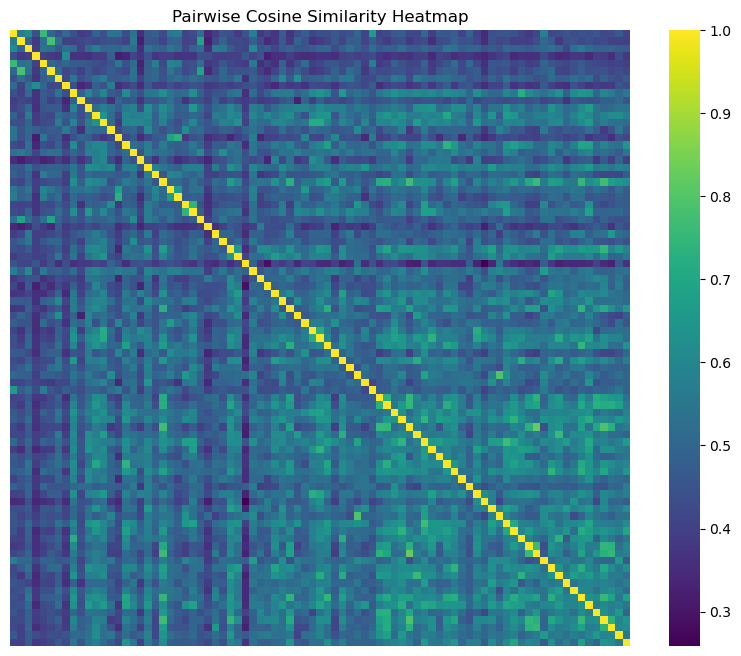

In [7]:
#plot heatmap of similarity matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=image_ids, yticklabels=image_ids, cmap='viridis')
#omit labels
plt.title("Pairwise Cosine Similarity Heatmap")
plt.xticks([])
plt.yticks([])

Above, we can neatly see the unity in self comparison on the diagonal, as expected for a deterministic model like mobile net.

The off-diagonals do isntead describe the similarity between pairs of images.

We can now plot the most similar image pairs in our dataset, as a sanity check

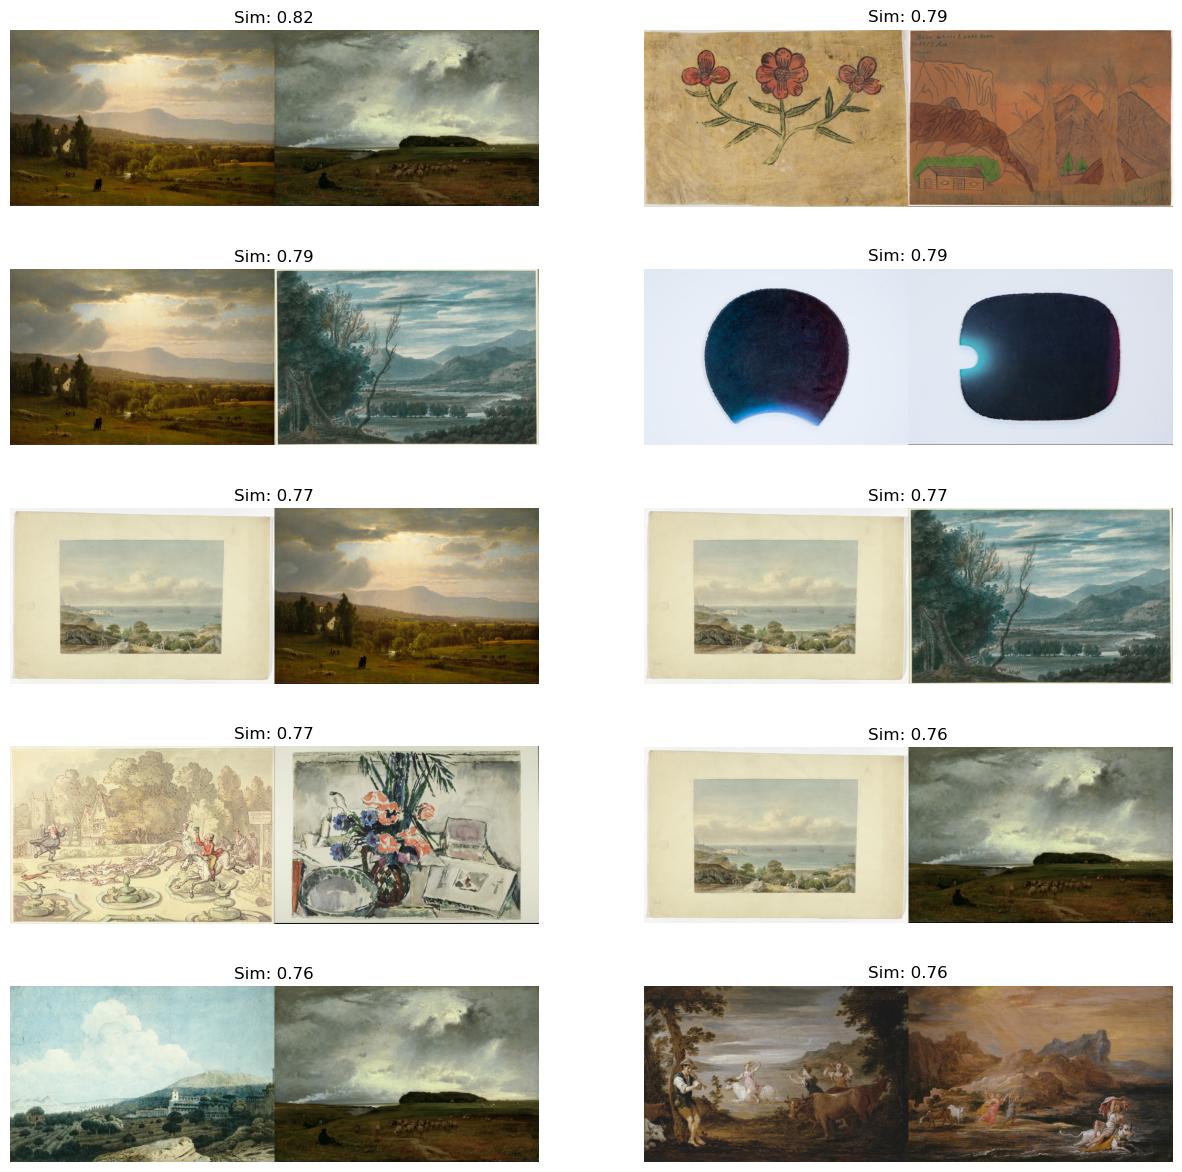

In [8]:
# find 10 most similar nondiagonal maximum similarity, make sure to count each pair only once
np.fill_diagonal(similarity_matrix, -1)  # Set diagonal to -1 to ignore self-similarity

# Get upper triangle indices to avoid counting pairs twice
upper_triangle = np.triu_indices_from(similarity_matrix, k=1)
upper_triangle_values = similarity_matrix[upper_triangle]

# Get indices of 10 highest values in upper triangle
top_10_indices = np.argpartition(upper_triangle_values, -10)[-10:]
top_10_indices = top_10_indices[np.argsort(upper_triangle_values[top_10_indices])[::-1]]

# Convert back to 2D indices
max_sim_indices = (upper_triangle[0][top_10_indices], upper_triangle[1][top_10_indices])

#plot the most similar image pairs
fig, axes = plt.subplots(5, 2, figsize=(15, 15))
for ax, (i, j) in zip(axes.flatten(), zip(*max_sim_indices)):
    img1 = Image.open(f"image_collection/{image_ids[i]}.jpg")
    img2 = Image.open(f"image_collection/{image_ids[j]}.jpg")
    combined_img = Image.new('RGB', (img1.width + img2.width, img1.height))
    combined_img.paste(img1, (0, 0))
    combined_img.paste(img2, (img1.width, 0))
    ax.imshow(combined_img)
    ax.axis('off')
    ax.set_title(f"Sim: {similarity_matrix[i, j]:.2f}")

Indeed, we can see quite some overlap in content and style between the images. This is especially striking in the second pair on the right column. Naturally, the matches are not perfect, and would get better for a larger base set.

As a further sanity check, we can also try out the most dissimilar pairs.

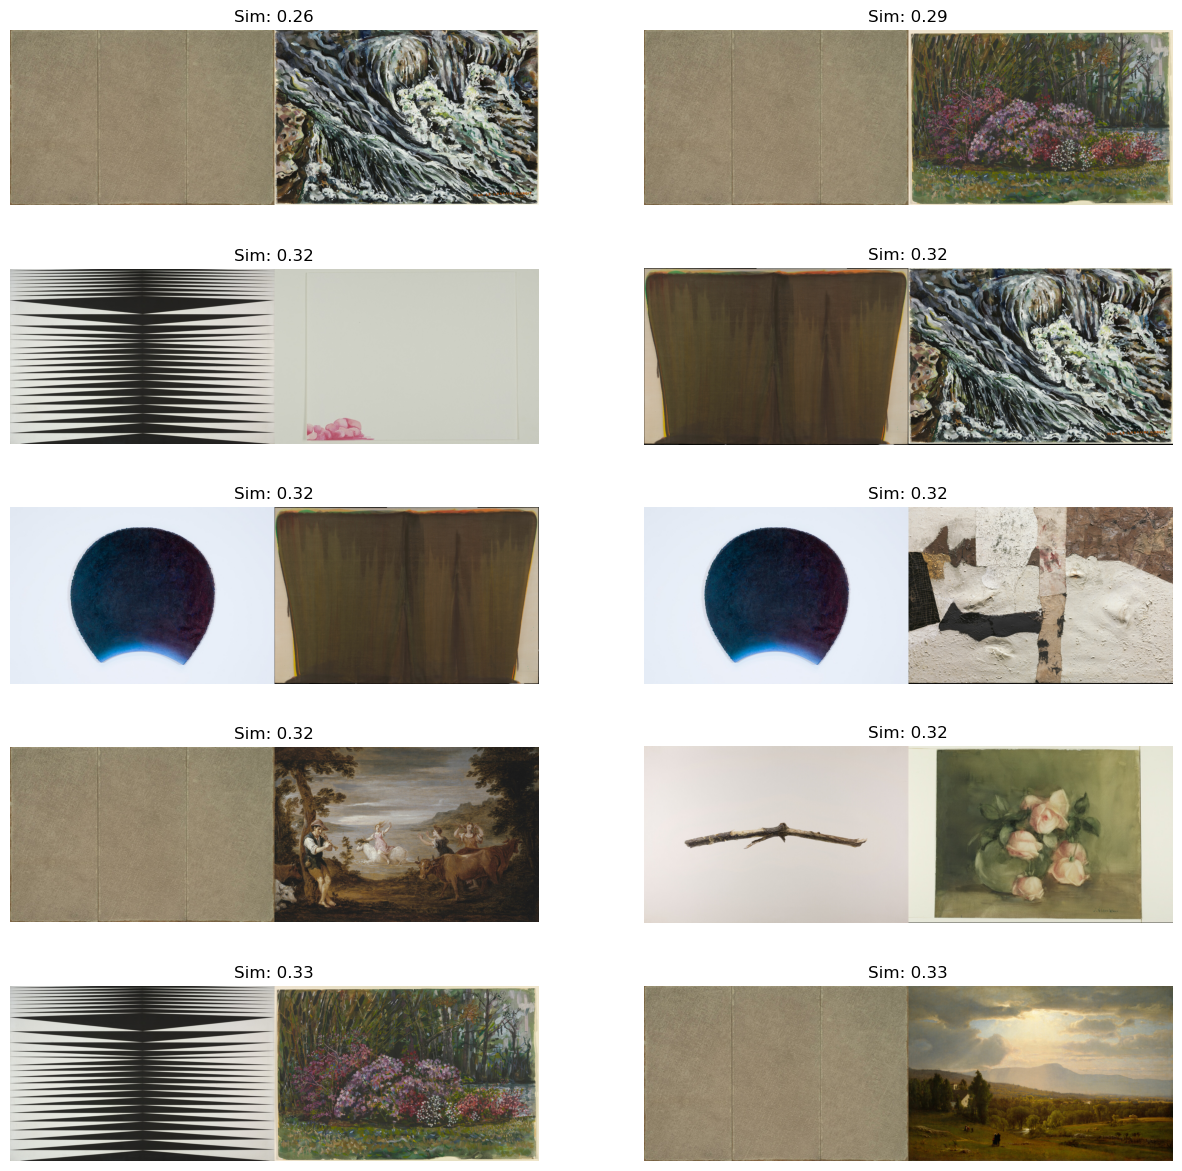

In [9]:
# find 10 most dissimilar nondiagonal minimum similarity, make sure to count each pair only once
np.fill_diagonal(similarity_matrix, 2)  # Set diagonal to 2 to ignore self-similarity (since we want minimum)

# Get upper triangle indices to avoid counting pairs twice
upper_triangle = np.triu_indices_from(similarity_matrix, k=1)
upper_triangle_values = similarity_matrix[upper_triangle]

# Get indices of 10 lowest values in upper triangle
bottom_10_indices = np.argpartition(upper_triangle_values, 10)[:10]
bottom_10_indices = bottom_10_indices[np.argsort(upper_triangle_values[bottom_10_indices])]

# Convert back to 2D indices
min_sim_indices = (upper_triangle[0][bottom_10_indices], upper_triangle[1][bottom_10_indices])

#plot the most dissimilar image pairs
fig, axes = plt.subplots(5, 2, figsize=(15, 15))
for ax, (i, j) in zip(axes.flatten(), zip(*min_sim_indices)):
    img1 = Image.open(f"image_collection/{image_ids[i]}.jpg")
    img2 = Image.open(f"image_collection/{image_ids[j]}.jpg")
    combined_img = Image.new('RGB', (img1.width + img2.width, img1.height))
    combined_img.paste(img1, (0, 0))
    combined_img.paste(img2, (img1.width, 0))
    ax.imshow(combined_img)
    ax.axis('off')
    ax.set_title(f"Sim: {similarity_matrix[i, j]:.2f}")

Yeah, these do not look similar at all.

## Memorability scores

As a side note, the original master list also includes a memorability judgement. Indeed, there exists a wealth of CNNs trained to predict memorability from Artworks. Here, we do not need to run any of them, and rather just collect the precomputed values from the master list.

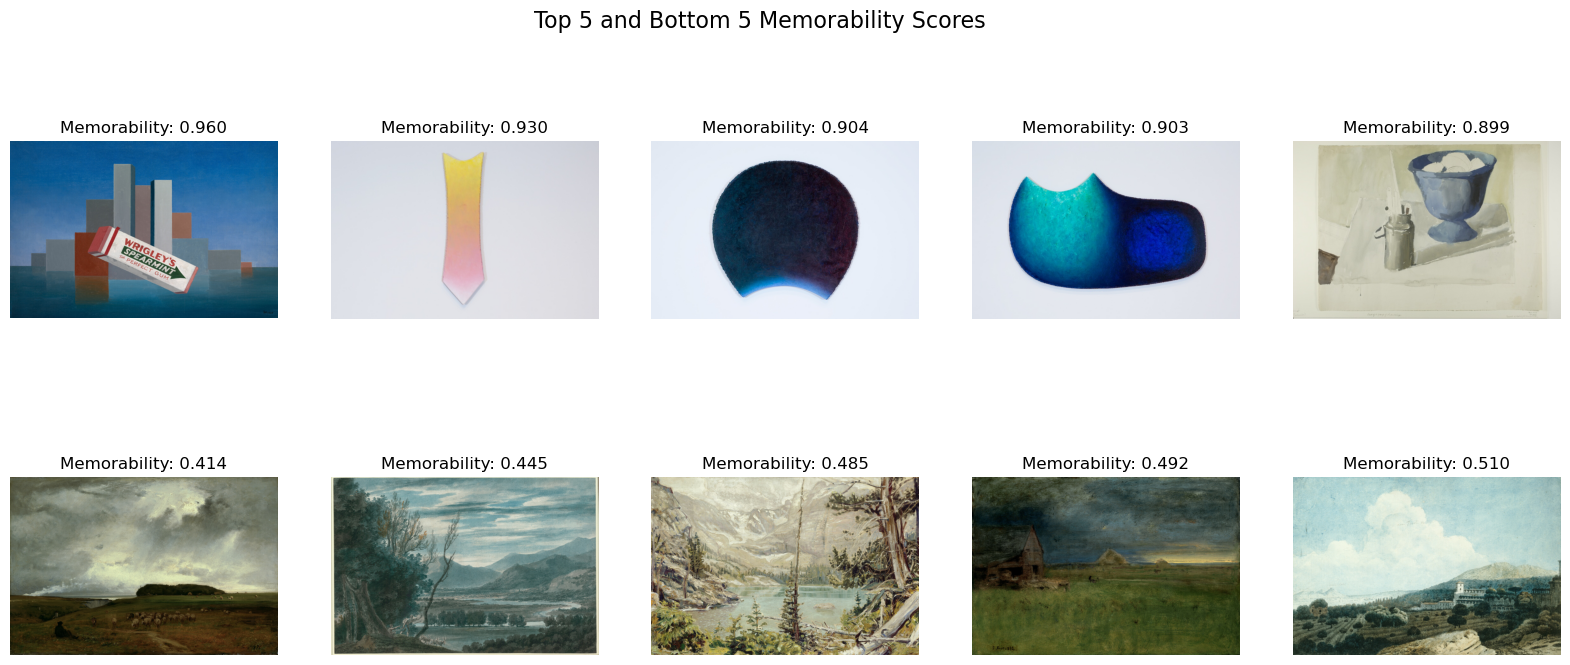

In [10]:
#plot the imges with the highest and lowest memorability scores
memorability_scores = filtered_df.set_index('image_id')['RESMEM']
top_5_memorability = memorability_scores.nlargest(5)
bottom_5_memorability = memorability_scores.nsmallest(5)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for ax, (image_id, score) in zip(axes[0], top_5_memorability.items()):
    img = Image.open(f"image_collection/{image_id}.jpg")
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Memorability: {score:.3f}")
plt.suptitle("Top 5 and Bottom 5 Memorability Scores", fontsize=16)
for ax, (image_id, score) in zip(axes[1], bottom_5_memorability.items()):
    img = Image.open(f"image_collection/{image_id}.jpg")
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Memorability: {score:.3f}")
    

Apparently, people confuse landscapes and remember bold, modern art.